
## Federated Learning for Distributed Network Anomaly Detection

### Centralized Federated Learning Workflow

![image.png](res/flworkflow.png)

### Centralized Federated Learning Training Loop

![image-2.png](res/flloop.png)

1. Send the same initialized model to clients
2. Each client trains the local model with E steps of SGD (e.g., one epoch)
3. Each client sends model back to aggregation server
4. Server aggregates model according to a Strategy
5. (optional) Server can perform centralized evaluation of model on global validation dataset. Or ask clients to also send evaluation of local/global model on local validation set
6. Server sends aggregated model to clients
7. (optional) Exit loop if model 
8. Go to 2

In [3]:
# Install prerequisites:
%pip install flwr
%pip install datasets
%pip install flwr_datasets

  Using cached cryptography-42.0.8-cp39-abi3-macosx_10_12_universal2.whl.metadata (5.3 kB)
  Using cached iterators-0.0.2-py3-none-any.whl.metadata (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 17.7 MB/s eta 0:00:0031m27.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 16.6 MB/s eta 0:00:001m16.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.68.0
    Uninstalling grpcio-1.68.0:
      Successfully uninstalled grpcio-1.68.0
  Attempting uninstall: cryptography
    Found existing installation: cryptography 44.0.0
    Uninstalling cryptography-44.0.0:
      Successfully uninstalled cryptography-44.0.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.simulation import run_simulation

from lib import XyDataset

## Create logger
import logging
from logging import DEBUG, ERROR, INFO, WARNING
# Use the same logger as flower to ensure synchronization
LOGGER_NAME = "flwr"
# Set log level to DEBUG
logging.getLogger(LOGGER_NAME).setLevel(logging.DEBUG)
# Create a log object 
log = logging.getLogger(LOGGER_NAME).log
#Example: log(INFO, "INFO message")

# Check if you have a GPU available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

# Show all columns
pd.set_option("display.max_columns", 150)

%load_ext autoreload
%autoreload 2

Training on cpu
Flower 1.13.1 / PyTorch 2.5.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset Preprocessing
#### Load dataset UNSW-NB15

Most works: binary classification (attack / not attack)

Our task is more complex: multi-class attack classification (which attack) from connection features and measurements

In [6]:
from sklearn.model_selection import train_test_split

# Load 10% of the training and testing datasets
data_train = pd.read_csv('datasets/UNSW_NB15_training-set.csv').sample(frac=0.2, random_state=42)
data_test = pd.read_csv('datasets/UNSW_NB15_testing-set.csv').sample(frac=0.2, random_state=42)

# We merge the datasets to create our own train and test datasets 
data = pd.concat([data_train, data_test], ignore_index=True)

# Drop columns
data = data.drop(['id','label'], axis=1)
data.rename(columns={'attack_cat': 'label'}, inplace=True)

# Identify numerical and categorical columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

# Print the lists
print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

# Shuffle the dataset data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Show the dataset
data

Categorical columns: ['proto', 'service', 'state', 'label']
Numerical columns: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.318433,tcp,http,FIN,10,6,2550,268,4.710567e+01,254,252,5.765734e+04,5.627558e+03,2,1,32.604000,52.781801,1895.825467,79.429414,255,34503991,2454433004,255,0.113198,0.054516,0.058682,255,45,1,0,6,1,2,2,1,6,0,0,1,2,6,0,Fuzzers
1,0.085934,tcp,-,FIN,66,68,3926,57474,1.547699e+03,31,29,3.599972e+05,5.271860e+06,7,27,1.357048,1.294576,0.000000,77.403403,255,2188717723,56306985,255,0.000774,0.000488,0.000286,59,845,0,0,11,0,1,1,1,5,0,0,0,5,6,0,Normal
2,0.000005,udp,dns,INT,2,0,114,0,2.000000e+05,254,0,9.120000e+07,0.000000e+00,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,3,0,0,0,4,12,0,Generic
3,0.000006,udp,dns,INT,2,0,114,0,1.666667e+05,254,0,7.600000e+07,0.000000e+00,0,0,0.006000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,17,2,17,17,17,17,0,0,0,18,17,0,Generic
4,0.001096,udp,dns,CON,2,2,146,178,2.737226e+03,31,29,5.328468e+05,6.496351e+05,0,0,0.011000,0.008000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,73,89,0,0,2,0,2,1,1,1,0,0,0,3,6,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51529,0.000009,udp,dns,INT,2,0,114,0,1.111111e+05,254,0,5.066666e+07,0.000000e+00,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,26,2,10,10,10,26,0,0,0,10,26,0,Generic
51530,0.000001,udp,-,INT,2,0,566,0,1.000000e+06,254,0,2.264000e+09,0.000000e+00,0,0,0.001000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,283,0,0,0,8,2,6,6,1,6,0,0,0,6,8,0,Fuzzers
51531,0.018657,tcp,-,FIN,16,18,1540,1644,1.768773e+03,31,29,6.191778e+05,6.659162e+05,4,4,1.221667,1.070353,74.144326,2.193405,255,3527355226,3527823974,255,0.000582,0.000457,0.000125,96,91,0,0,6,0,3,3,1,2,0,0,0,5,4,0,Normal
51532,0.000009,udp,dns,INT,2,0,114,0,1.111111e+05,254,0,5.066666e+07,0.000000e+00,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,20,2,18,17,17,20,0,0,0,17,20,0,Generic


Create two DataFrames containing inputs and labels

In [7]:
# Separating features and labels
X_sep = data.drop(['label'], axis=1)  # Features
y_sep = data[['label']]  # Labels

Perform Standard scaling of numerical variables in the input DataFrame

$$z=\frac{x-\mu}{\sigma}$$

In [8]:
from sklearn.preprocessing import StandardScaler

# Numerical feature scaling
scaler = StandardScaler()
X_sep[numerical_columns] = scaler.fit_transform(X_sep[numerical_columns])

One-hot encode categorical variables in input and label DataFrames

![image.png](res/onehot.png)

In [9]:
# Categorical feature encoding

from lib import one_hot_encode

categorical_columns_X = [x for x in categorical_columns if x not in ['label'] ]
X = one_hot_encode(X_sep, categorical_columns_X)

categorical_columns_y = ['label']
y = one_hot_encode(y_sep, categorical_columns_y)
# y = y_sep

At this point, X contains the one-hot-encoded and scaled inputs, and y contains the one-hot-encoded labels

In [10]:
# Select data size to build input and output layers of neural network
input_size = X.shape[1]
num_classes = y.shape[1]
print(f"Input size: {input_size}, Number of classes: {num_classes}")

Input size: 192, Number of classes: 10


Create global training and test datasets 

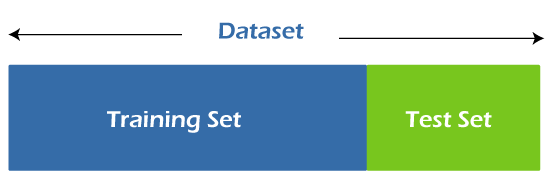

In [12]:
# Split the data into train and test sets with 50% proportion
# train_data, test_data = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200 , random_state=42, shuffle=True) #test_size=0.995

# Print the shapes of the resulting datasets
print("Train dataset shape:", X_train.shape, type(X_train))
print("Train labels shape:", y_train.shape, type(y_train))
print("Test dataset shape:", X_test.shape, type(X_test))
print("Test labels shape:", y_test.shape, type(y_test))

Train dataset shape: (200, 192) <class 'pandas.core.frame.DataFrame'>
Train labels shape: (200, 10) <class 'pandas.core.frame.DataFrame'>
Test dataset shape: (51334, 192) <class 'pandas.core.frame.DataFrame'>
Test labels shape: (51334, 10) <class 'pandas.core.frame.DataFrame'>


In [13]:
# # # Convert to PyTorch tensors
# X_train = torch.FloatTensor(X_train.values)
# X_test = torch.FloatTensor(X_test.values)
# y_train = torch.LongTensor(y_train.values)
# y_test = torch.LongTensor(y_test.values)

# # # Observe the highly imbalanced sizes of training and test sets
# print("Train dataset shape:", X_train.shape, type(X_train))
# print("Train labels shape:", y_train.shape, type(y_train))
# print("Test dataset shape:", X_test.shape, type(X_test))
# print("Test labels shape:", y_test.shape, type(y_test))

#### Create one DataLoader for the whole test dataset

In [15]:
BATCH_SIZE_TEST = 1024

def make_testloader(X_test, y_test):
    # Convert test data to PyTorch tensors
    print("Test DataFrame dataset shape:", X_test.shape, type(X_test))
    print("Test DataFrame labels shape:", y_test.shape, type(y_test))
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32) # TODO: This could be dtype=torch.long. Need to convert list elements to int

    # Deprecated approach
    # X_test_tensor = torch.FloatTensor(X_test.values)
    # y_test_tensor = torch.LongTensor(y_test.values) 

    # Observe the shapes of the input and output tensors
    print("Test Tensor dataset shape:", X_test_tensor.shape, type(X_test_tensor))
    print("Test Tensor labels shape:", y_test_tensor.shape, type(y_test_tensor))

    # Create XyDataset dataset object from test sensors
    test_dataset = XyDataset(X_test_tensor, y_test_tensor)

    # Create a DataLoader from the test dataset, which provides a batch iterator of size 1024
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)
    print(type(testloader))

    return testloader, X_test_tensor, y_test_tensor

testloader, X_test_tensor, y_test_tensor = make_testloader(X_test, y_test)


Test DataFrame dataset shape: (51334, 192) <class 'pandas.core.frame.DataFrame'>
Test DataFrame labels shape: (51334, 10) <class 'pandas.core.frame.DataFrame'>
Test Tensor dataset shape: torch.Size([51334, 192]) <class 'torch.Tensor'>
Test Tensor labels shape: torch.Size([51334, 10]) <class 'torch.Tensor'>
<class 'torch.utils.data.dataloader.DataLoader'>


#### Select number of aggregation rounds

In [16]:
# In the isolated case this is the same as the number of epochs
NUM_ROUNDS_IID = 50
NUM_ROUNDS_NONIID = 50

#### Check the performance of a centralized model trained on a centralized dataset

Define a function to perform training and testing on a model for a certain number of epochs

In [17]:
from lib import training, evaluation
import torch.optim as optim
from lib import FFNN_Tiny
import torch.nn as nn

def train_and_test(input_size: int, num_classes: int, trainloader: DataLoader, testloader: DataLoader, num_rounds: int = 30, device: str = "cpu"): 
    '''
    Trains and tests a FFNN_Tiny model on the given data loaders for a specified number of rounds.
    '''
    
    # Initialize model, loss function, and optimizer
    model = FFNN_Tiny(input_size, num_classes)
    criterion = nn.BCEWithLogitsLoss()  # For multi-class classification with one-hot output
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_metrics = pd.DataFrame()
    test_metrics = pd.DataFrame()

    for epoch in range(num_rounds):
        train_metric = training(model, optimizer, criterion, trainloader, device)
        train_metrics = pd.concat([train_metrics, pd.DataFrame([train_metric])], ignore_index=True)
        print("Epoch", epoch, "Train", train_metric)

        test_metric = evaluation(model, criterion, testloader, device)
        test_metrics = pd.concat([test_metrics, pd.DataFrame([test_metric])], ignore_index=True)
        print("Epoch", epoch, "Test", test_metric)

    # Add a round column shifting the index to start from 1
    train_metrics['round'] = train_metrics.index+1
    test_metrics['round'] = test_metrics.index+1
    
    return train_metrics, test_metrics

Create a train_loader on the whole training dataset

In [18]:
# Test of local training on one partition from training dataset

# Create DataLoader for training set
BATCH_SIZE_TRAIN = 32

# Convert training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32) # TODO: This could be dtype=torch.long. Need to convert list elements to int

# Create XyDataset dataset object from test sensors
train_dataset = XyDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

Train and test

In [19]:

# Compute train and test metrics
train_metrics_centralized, test_metrics_centralized = train_and_test(input_size, num_classes, train_loader, testloader, np.max([NUM_ROUNDS_IID,NUM_ROUNDS_NONIID]), DEVICE)

Epoch 0 Train {'loss': 0.6864738804953439, 'accuracy': 0.19, 'precision': 0.39198362164151634, 'recall': 0.19, 'f1': 0.23998395032550543}
Epoch 0 Test {'loss': 0.6781941254933676, 'accuracy': 0.34343709821950363, 'precision': 0.41843545698984397, 'recall': 0.34343709821950363, 'f1': 0.3663337824191915}
Epoch 1 Train {'loss': 0.6654609612056187, 'accuracy': 0.34, 'precision': 0.46687046802900467, 'recall': 0.34, 'f1': 0.37921907679437017}
Epoch 1 Test {'loss': 0.6628179713791492, 'accuracy': 0.3855923949039623, 'precision': 0.4328525572020831, 'recall': 0.3855923949039623, 'f1': 0.40053977159634657}
Epoch 2 Train {'loss': 0.6481451988220215, 'accuracy': 0.375, 'precision': 0.46101949064449066, 'recall': 0.375, 'f1': 0.40378046470946855}
Epoch 2 Test {'loss': 0.6485696773903042, 'accuracy': 0.4180465188763782, 'precision': 0.4348181119214626, 'recall': 0.4180465188763782, 'f1': 0.42041188092856413}
Epoch 3 Train {'loss': 0.6298529420580182, 'accuracy': 0.405, 'precision': 0.4492720685111

#### Visualize centralized model performance

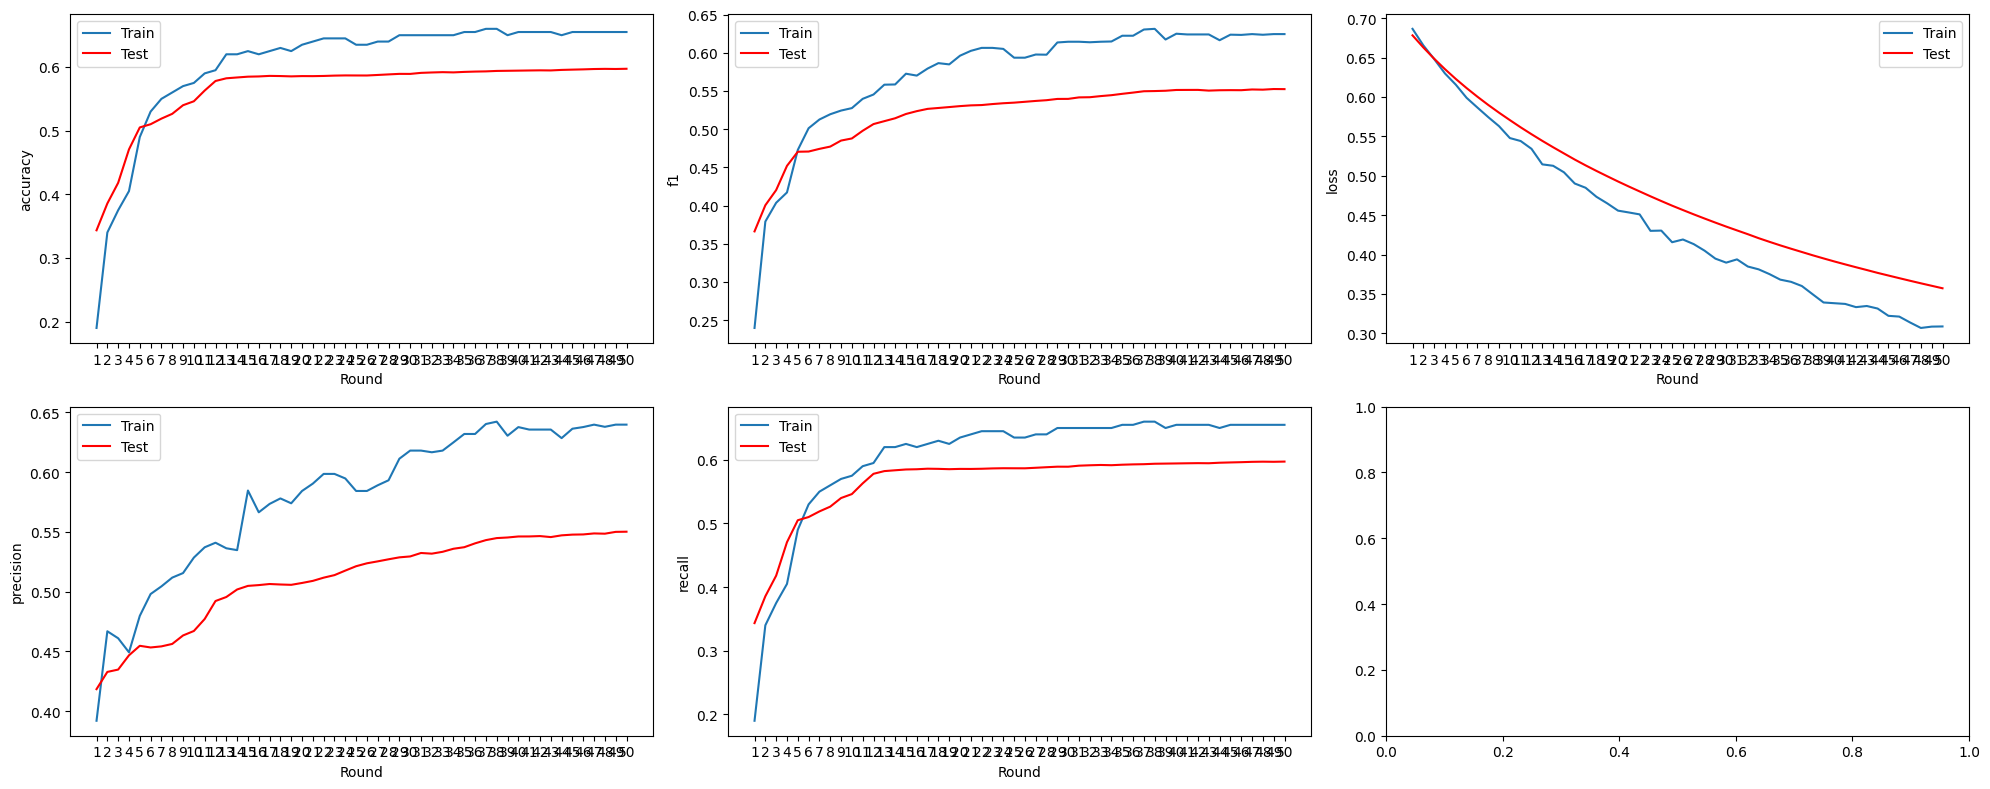

In [20]:
from lib import plot_metrics

plot_metrics(train_metrics_centralized, test_metrics_centralized)

Comments on plots:
1. No overfitting


#### Create one Dataset object for the whole dataset, to feed into partitioners, which return individual DataLoaders

In [22]:
from datasets import Dataset

# Create a Dataset object from the training dataset (Pandas DataFrame format)
train_dataset = Dataset.from_dict({
    "input": X_train.values.tolist(),
    "output": y_train.values.tolist(),
    "label": y_train.values.argmax(axis=1).tolist() # This numerical encoding is needed for the partitioner. It cannot handle one-hot-encoded labels.
})
print(type(train_dataset), train_dataset)

<class 'datasets.arrow_dataset.Dataset'> Dataset({
    features: ['input', 'output', 'label'],
    num_rows: 200
})


#### Check the per-partition label distribution after partitioning the training dataset with different strategies
#### Observe different generation techniques of local label distribution. Label non-IIDness is one type of non-IIDness.

/Users/borito/.pyenv/versions/3.10.7/lib/python3.10/site-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


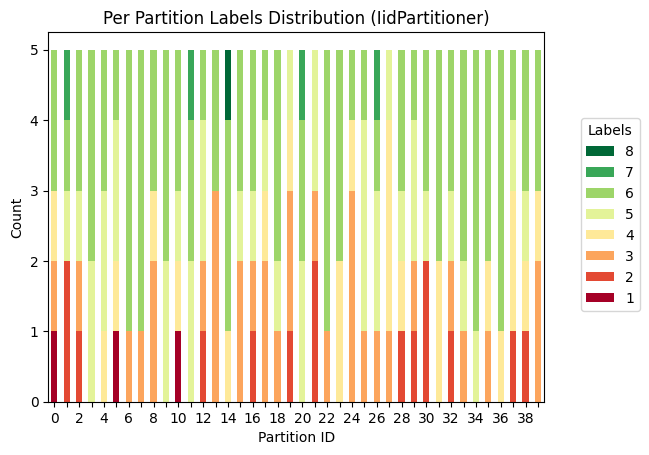

/Users/borito/.pyenv/versions/3.10.7/lib/python3.10/site-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


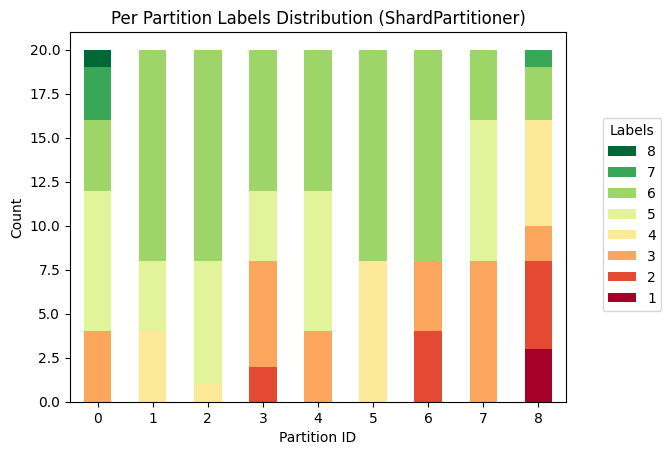

/Users/borito/.pyenv/versions/3.10.7/lib/python3.10/site-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


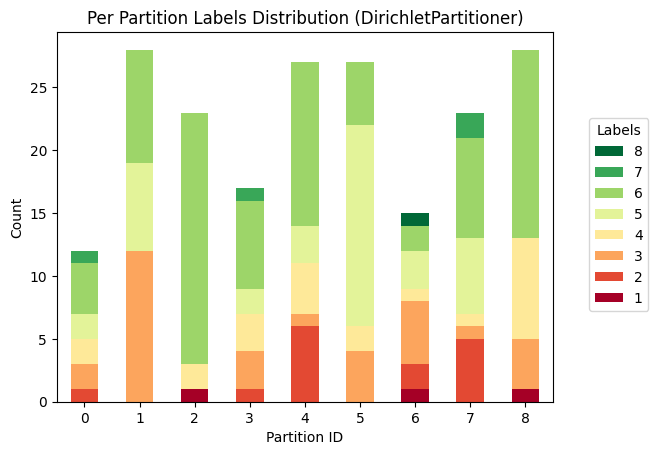

/Users/borito/.pyenv/versions/3.10.7/lib/python3.10/site-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


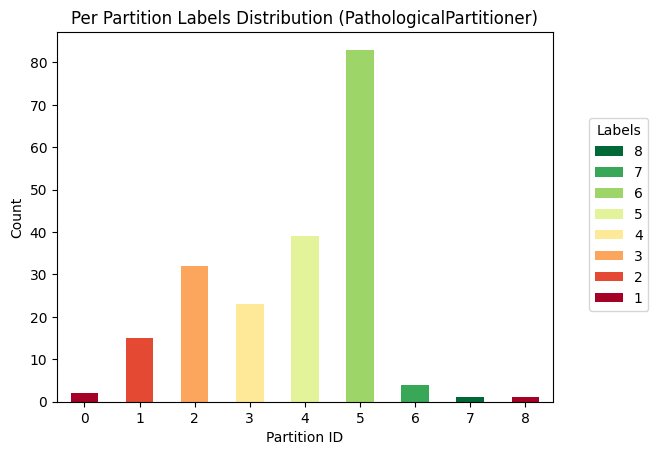

In [23]:

# from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.partitioner import InnerDirichletPartitioner
from flwr_datasets.partitioner import PathologicalPartitioner
from flwr_datasets.partitioner import ShardPartitioner

# NUM_CLIENTS = 90 with 1546 samples overall

# Number of federated learning clients
NUM_CLIENTS_IID = 40 #60
NUM_CLIENTS_NONIID = 9

## Create partitioners

### IID Partitioner: Balanced size and IID labels
iid_partitioner = IidPartitioner(num_partitions=NUM_CLIENTS_IID)
# Actually this is a simple sharder: just split the dataset into equal parts without shuffling
# If you need true IID, you have to remember shuffling the dataset before splitting
# This Class also works directly with one-hot-encoded labels

### Dirichlet Partitioner: Imbalanced size and non-IID labels
dirichlet_partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS_NONIID, alpha=2, partition_by="label", seed=4, self_balancing=True)

### Shard Partitioner: Balanced size and non-IID labels
# Operation: sort the dataset by label, then split it into num_partitions parts of size shard_size, then randomly assign num_shards_per_partition shards to each partition
num_shards_per_partition = 5
#Automatically calculated: shard_size = int(int(len(train_dataset)/NUM_CLIENTS_NONIID)/num_shards_per_partition)
shard_partitioner = ShardPartitioner(num_partitions=NUM_CLIENTS_NONIID, partition_by="label", num_shards_per_partition=num_shards_per_partition)
# This Class does not work with one-hot-encoded labels

### Pathological Partitioner: Imbalanced size and extremely non-IID labels
pathological_partitioner = PathologicalPartitioner(num_partitions=NUM_CLIENTS_NONIID, partition_by="label", seed=4, num_classes_per_partition=1, class_assignment_mode="deterministic")#, class_assignment_mode="deterministic"

# The following lines are to check the partition label-distribution from the global dataset
# Format entire dataset into HuggingFace format
# dataset = Dataset.from_pandas(data)
# iid_partitioner.dataset = dataset
# dirichlet_partitioner.dataset = dataset
# shard_partitioner.dataset = dataset
# pathological_partitioner.dataset = dataset

# Assign the dataset to the partitioner
iid_partitioner.dataset = train_dataset
dirichlet_partitioner.dataset = train_dataset
shard_partitioner.dataset = train_dataset
pathological_partitioner.dataset = train_dataset

# Visualize the distributions
from flwr_datasets.visualization import plot_label_distributions

# Note: This generates an error because the partitioner expects a HuggingFace dataset Dataset
# from torch.utils.data import TensorDataset
# iid_partitioner.dataset = TensorDataset(X_train, y_train)
list_of_partitioners = [iid_partitioner, shard_partitioner, dirichlet_partitioner, pathological_partitioner] #, pathological_partitioner, dirichlet_partitioner] pathological_partitioner dirichlet_partitioner

for i, partitioner in enumerate(list_of_partitioners):
    fig, ax, df = plot_label_distributions(
        partitioner,
        label_name="label",
        plot_type="bar",
        size_unit="absolute",
        partition_id_axis="x",
        legend=True,
        verbose_labels=True,
        title=f"Per Partition Labels Distribution ({partitioner.__class__.__name__})",
    )

    plt.show()

#### Create function that returns a DataLoader object for the partition partition_id generated from partitioner

In [24]:
from lib import XyDataset

def get_dataloader(partitioner, partition_id: int, BATCH_SIZE: int):

    # Create a Local Dataset using the Partitioner to select a partition with id partition_id 
    partitioned_dataset = partitioner.load_partition(partition_id=partition_id)

    # Convert partitioned data back to PyTorch Tensors for training
    X_partition = torch.tensor([x for x in partitioned_dataset['input']], dtype=torch.float32)
    y_partition = torch.tensor([y for y in partitioned_dataset['output']], dtype=torch.float32) # TODO: This could be dtype=torch.long. Need to convert list elements to int

    # Report the shape of the partitioned data
    print(f"Created Partition {partition_id} - X: {X_partition.shape}, y: {y_partition.shape}")

    # Older approach
    # X_partition = torch.FloatTensor([x for x in partitioned_dataset['input']])
    # y_partition = torch.LongTensor([y for y in partitioned_dataset['output']])
    
    # TODO: Do both work?
    # dataset = TensorDataset(X_partition, y_partition)
    dataset = XyDataset(X_partition, y_partition)
    
    # Wraps the Dataset into a DataLoader
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    return dataloader


#### Set simulation parameters 

In [26]:
# Select the shard partitioner
train_partitioner = iid_partitioner

#### Example of performance on isolated nodes, no communication, no aggregation

In [27]:
# Test of local training on one partition from training dataset

from lib import training, evaluation
import torch.optim as optim
from lib import FFNN_Tiny
import torch.nn as nn

# Create DataLoader for partition with id partition_id=0
BATCH_SIZE_TRAIN = 32
partition_id = 0
train_loader = get_dataloader(train_partitioner, partition_id, BATCH_SIZE_TRAIN)

def train_test_all(train_partitioner, num_clients, batch_size_train, num_rounds, device):
    ''' Performs independent training and testing on all clients. '''

    # Initialize return variables
    train_metrics = pd.DataFrame()
    test_metrics = pd.DataFrame()

    for partition_id in range(0, num_clients):
        train_loader = get_dataloader(train_partitioner, partition_id, batch_size_train)
        train_metrics_partition, test_metrics_partition = train_and_test(input_size, num_classes, train_loader, testloader, num_rounds, device)
        train_metrics_partition['client_id'] = partition_id
        test_metrics_partition['client_id'] = partition_id
        train_metrics = pd.concat([train_metrics, train_metrics_partition], ignore_index=True)
        test_metrics = pd.concat([test_metrics, test_metrics_partition], ignore_index=True)
    
    return train_metrics, test_metrics

Created Partition 0 - X: torch.Size([5, 192]), y: torch.Size([5, 10])


In [28]:
# Train and test on one client
# train_metrics, test_metrics = train_test_all(train_partitioner, 0, BATCH_SIZE_TRAIN, NUM_ROUNDS_IID, DEVICE)

# Train and test on all clients
# train_metrics_iid, test_metrics_iid =  train_test_all(train_partitioner, NUM_CLIENTS_IID, BATCH_SIZE_TRAIN, NUM_ROUNDS_IID, DEVICE)
train_metrics_iid, test_metrics_iid =  train_test_all(train_partitioner, 10, BATCH_SIZE_TRAIN, NUM_ROUNDS_IID, DEVICE)

Created Partition 0 - X: torch.Size([5, 192]), y: torch.Size([5, 10])
Epoch 0 Train {'loss': 0.6878659129142761, 'accuracy': 0.2, 'precision': 0.1, 'recall': 0.2, 'f1': 0.13333333333333333}
Epoch 0 Test {'loss': 0.6981985311882168, 'accuracy': 0.07809638835859274, 'precision': 0.1725238814224984, 'recall': 0.07809638835859274, 'f1': 0.09626363202659231}
Epoch 1 Train {'loss': 0.6822030544281006, 'accuracy': 0.2, 'precision': 0.1, 'recall': 0.2, 'f1': 0.13333333333333333}
Epoch 1 Test {'loss': 0.6967185537020365, 'accuracy': 0.08690146881209335, 'precision': 0.17713882140727025, 'recall': 0.08690146881209335, 'f1': 0.10543481686458717}
Epoch 2 Train {'loss': 0.6765817403793335, 'accuracy': 0.2, 'precision': 0.1, 'recall': 0.2, 'f1': 0.13333333333333333}
Epoch 2 Test {'loss': 0.6952626144184786, 'accuracy': 0.10125842521525695, 'precision': 0.18807201299460594, 'recall': 0.10125842521525695, 'f1': 0.12091313835289419}
Epoch 3 Train {'loss': 0.6710026264190674, 'accuracy': 0.2, 'precision

Visualize the training and test performance in IID scenario without any user interaction

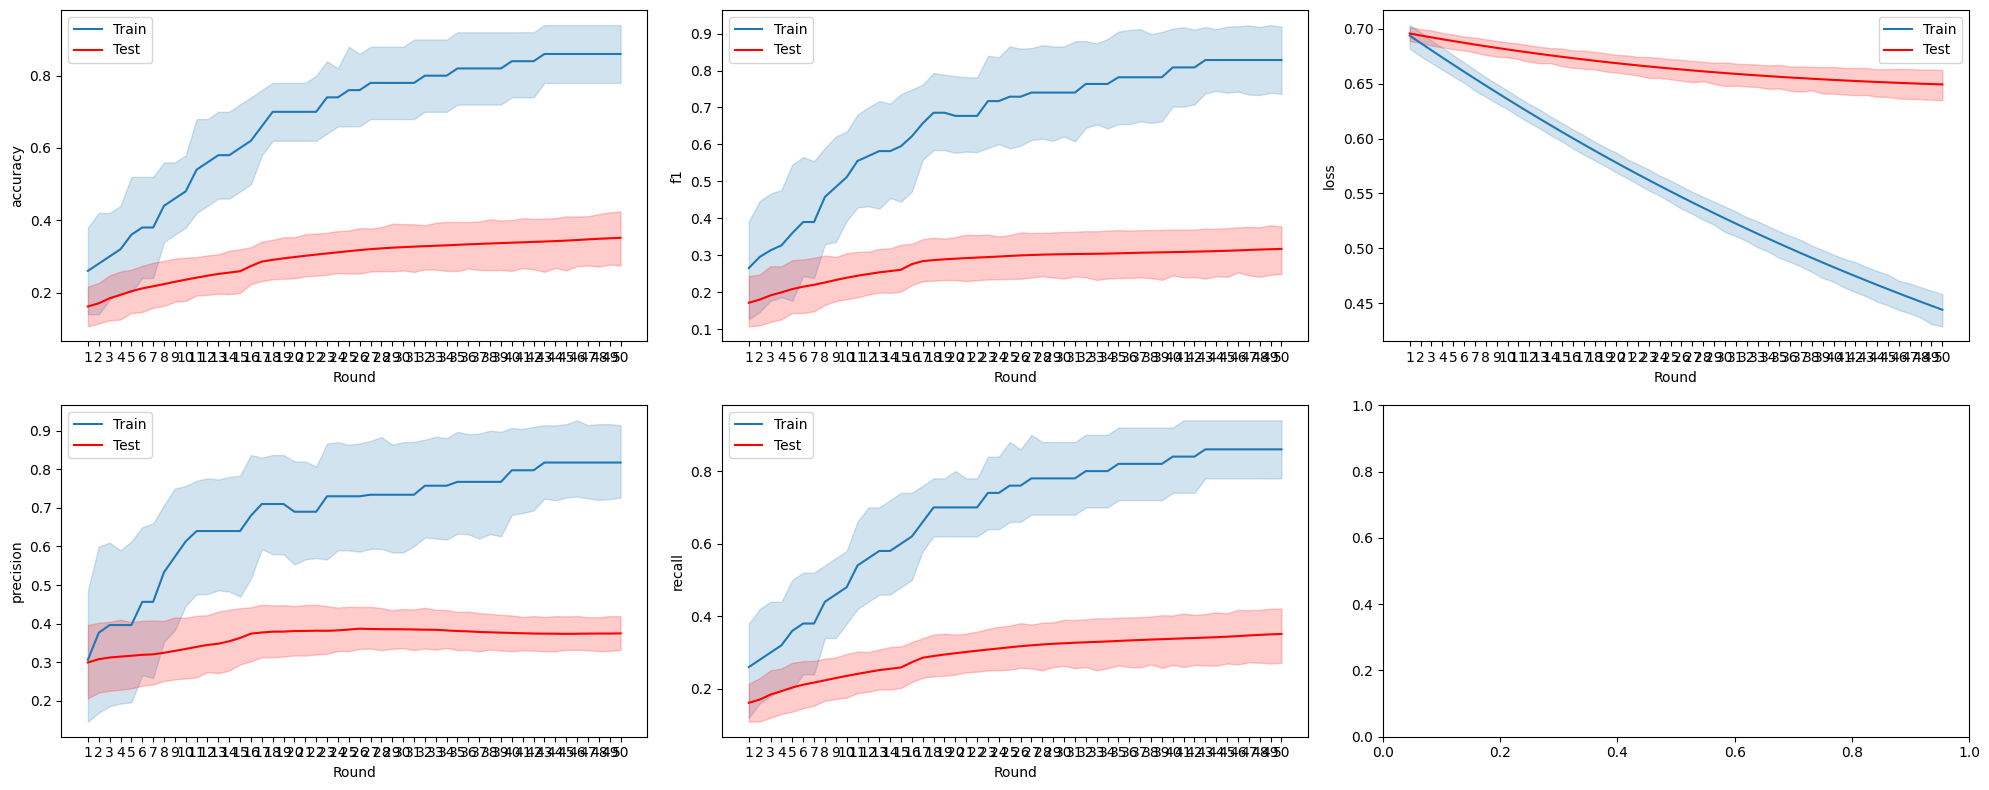

<Figure size 640x480 with 0 Axes>

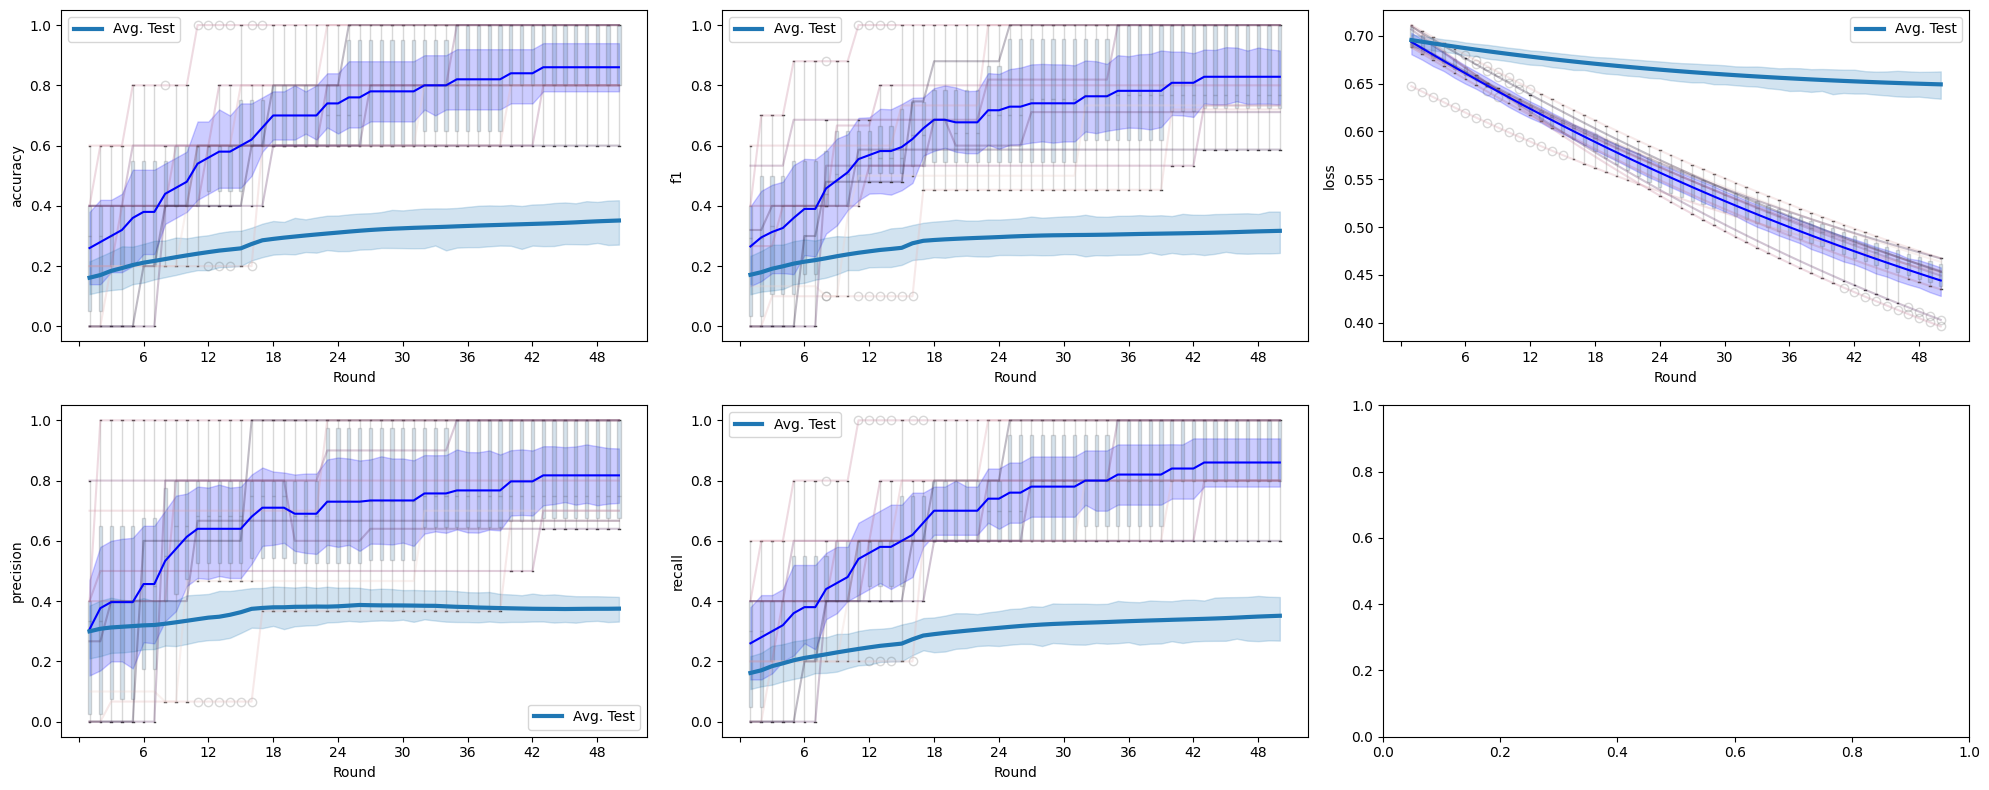

<Figure size 640x480 with 0 Axes>

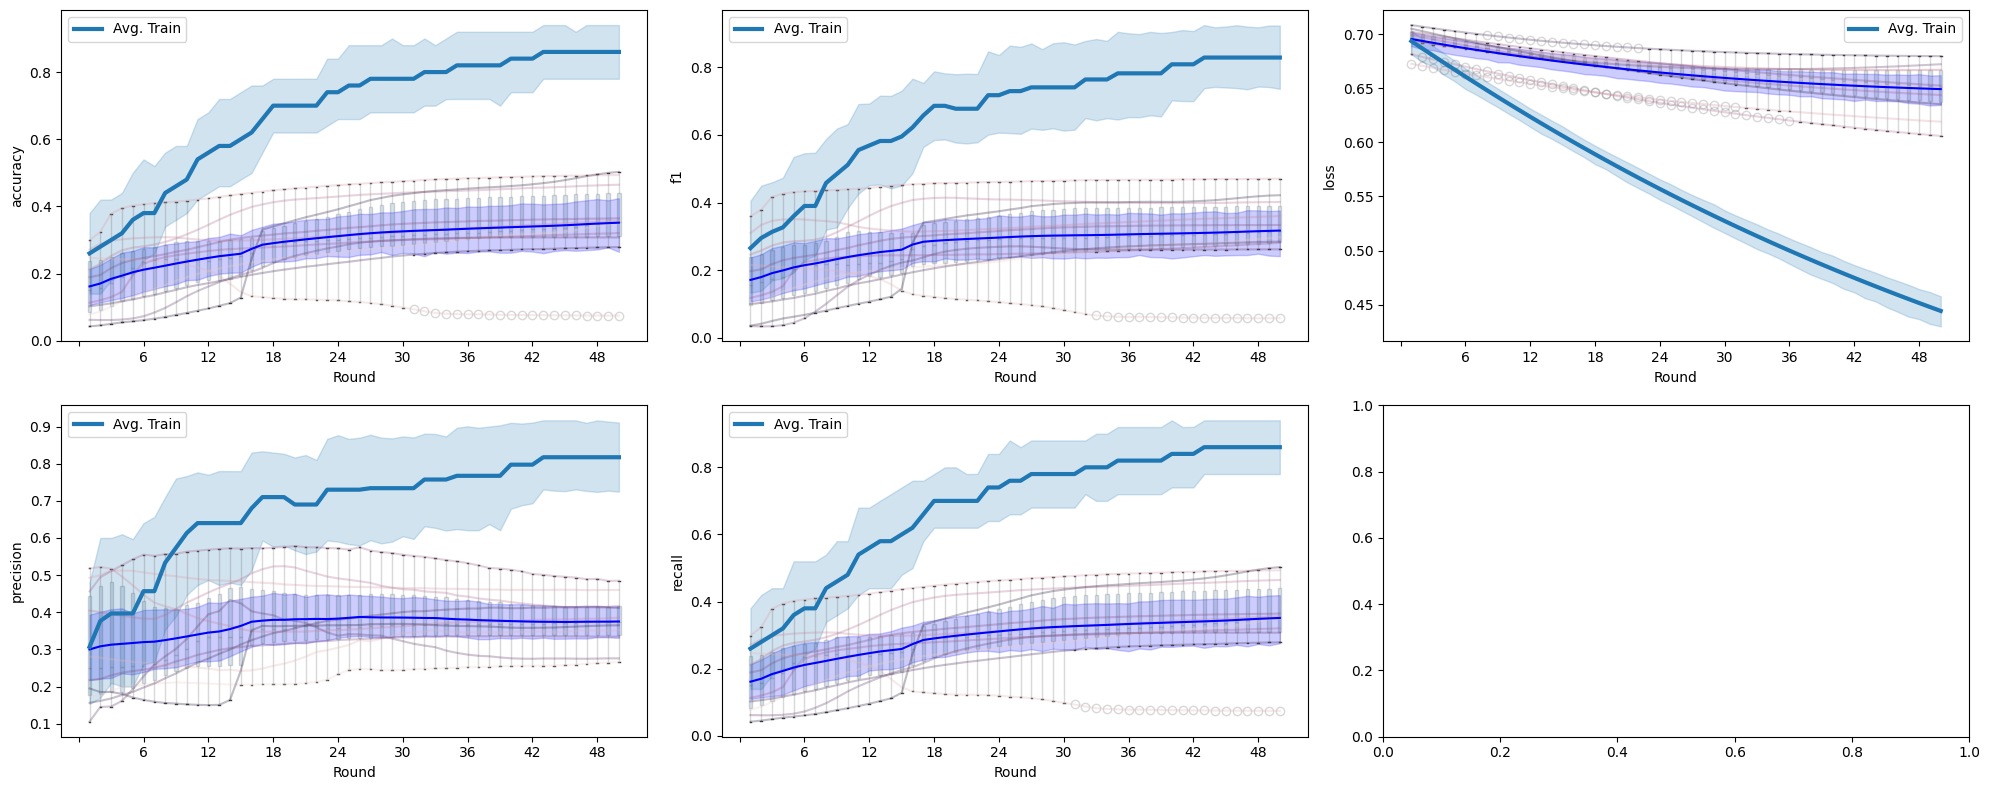

In [32]:
from lib import plot_metrics
from lib import plot_metrics_full

plot_metrics(train_metrics_iid, test_metrics_iid)
plot_metrics_full(train_metrics_iid, ('Avg. Test', test_metrics_iid))
plot_metrics_full(test_metrics_iid, ('Avg. Train', train_metrics_iid))

#### Define the Flower Client class with distributed training and centralized evaluation

At every round, the fit method is called. Then the updated parameters are collected with a get_parameters and sent to server for the aggregation.
The fit method receives the parameters in input and overwrites the weights of the local model. Then performs a number of model updates based on gradient descent.

In [34]:
# Define Flower Client with distributed training and centralized evaluation

from lib import get_parameters, set_parameters

# Inherit NumpyClient ()
class FlowerClient(NumPyClient):
    def __init__(self, model, optimizer, criterion, train_loader, epochs_per_round):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.epochs_per_round = epochs_per_round

    def get_parameters(self, config):
        return get_parameters(self.model)

    # Update the model parameters with the received parameters and train the model for epochs_per_round epochs
    def fit(self, parameters, config):

        # Set the received parameters in the model
        set_parameters(self.model, parameters)

        # Train the model for epochs_per_round epochs
        # TODO: this can become NUM_STEPS_PER_ROUND instead of NUM_EPOCHS
        for _ in range(self.epochs_per_round):
            train_metric = training(self.model, self.optimizer, self.criterion, self.train_loader, DEVICE)
        return get_parameters(self.model), len(self.train_loader), train_metric

#### Define a "Client Builder" callback function
Define a "Client Builder" callback function that returns a FlowerClient object with parameters specified in the Context
For example, the context contains the node_config which can be used to fetch the partition_id for the client

In [35]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a device. Configuration is provided as a `Context` object."""

    # Initialize model
    model = FFNN_Tiny(input_size, num_classes)

    # Get node id
    partition_id = context.node_config["partition-id"]

    # Read the node_config to fetch data partition associated to this node
    train_loader = get_dataloader(train_partitioner, partition_id, BATCH_SIZE_TRAIN) # train_partitioner is global

    # Report client details
    log(INFO, f"Client {partition_id} created with {len(train_loader)} mini-batches of size {BATCH_SIZE_TRAIN}") 
    
    # Get Loss function (For multi-class classification with one-hot output)
    criterion = nn.BCEWithLogitsLoss()
    
    # Create a stateful optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create and return a single Flower client representing a device
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, optimizer, criterion, train_loader, epochs_per_round=1).to_client()

#### Define centralized evaluation function for the server
Important: note how the testloader is embedded in the function and the model is passed as a parameter

In [36]:
from flwr.common import NDArrays, Scalar
from typing import Dict, Optional, Tuple

# Used as global variables
# X_test_tensor
# y_test_tensor
# BATCH_SIZE_TEST

# The input is the model copy on the server and the output is the function that evaluates the model
def get_centr_eval_fn(model, criterion):
    """Return a stateful evaluation function for server-side evaluation."""
    
    # Create a test dataset object from raw tensors
    test_dataset = XyDataset(X_test_tensor, y_test_tensor)

    # Create a DataLoader for the evaluation function on the server
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)    

    # The evaluate function will be called after every round at the server
    def centr_eval_fn(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        
        # model.set_weights(parameters)  # Update model with the latest parameters
        set_parameters(model, parameters)
        log(INFO, "Calling centralized aggregated model evaluation...")
        test_metric = evaluation(model, criterion, testloader, DEVICE)
        log(INFO, "Finished. Results will be at fit_progress")

        return test_metric['loss'], test_metric

    # Return the stateful evaluation function that contains the test dataset
    return centr_eval_fn

### Create a Federation Strategy

Specify server-side parameters for the client's model aggregation and collection. After every aggregation, performs centralized evaluation by calling evaluate_fn.

The fit method returns a list of tuples (number_of_examples, {metric_key: metric_value}) containing each client's metrics report.

--> number_of_examples = length of dataset =  number of mini-batches per epoch (in mini-batch gradient descent)

Example: [(15, {'accuracy': 0.4, 'loss': 0.2, 'round': 17, 'client_id': '56'}), (...), (...), ...]

fit_progress shows the performance of the aggregated global model: (num_round, loss, custom_metrics, wall_clock_elapsed_time_evaluation_seconds)

Example: (1, 0.6, {'loss': 0.6, 'accuracy': 0.4}, 15.096)

In [37]:
# Define the server strategy (e.g., FedAvg aggregation, etc.) with centralized evaluation and model initialization

from flwr.server.strategy import FedAvg
from flwr.common import ndarrays_to_parameters
from lib import all_metrics

strategy = FedAvg(
    fraction_fit = 1.0,  # Try to sample a proportion fraction_fit of available clients for training
    min_fit_clients = NUM_CLIENTS_IID,  # Min number of clients to send their updates to the server before aggregation (this is different than fraction_fit: it is a minimum hard limit, fraction_fit is a desired proportion)
    min_available_clients = NUM_CLIENTS_IID,  # Min number of clients that should be connected to the server (if not, the server waits)
    fit_metrics_aggregation_fn = all_metrics,  # Report all metrics for centralized evaluation
    fraction_evaluate = 0.0,  # No client evaluation
    evaluate_metrics_aggregation_fn = None, # No client evaluation --> centralized evaluation
    evaluate_fn = get_centr_eval_fn(FFNN_Tiny(input_size,num_classes).to(DEVICE), nn.BCEWithLogitsLoss()),  # Selects evaluation function (on centralized testset)
    initial_parameters = ndarrays_to_parameters(get_parameters(FFNN_Tiny(input_size,num_classes)))  # Set initial model parameters (optional)
)

#### Define the server builder function
It takes the Context and returns a configured (e.g., number of rounds) ServerAppComponents object

In [38]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour."""

    # Configure the server for NUM_ROUNDS_IID rounds of training (in the base class is the only param)
    # Set a round timeout of 10 minutes (optional)
    config = ServerConfig(num_rounds=NUM_ROUNDS_IID, round_timeout=600) # NUM_ROUNDS_IID is a global variable

    log(INFO, f"Aggregation server is using strategy: {strategy.__class__.__name__}")

    return ServerAppComponents(strategy=strategy, config=config) # strategy is a global variable

In [39]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

print(backend_config)

{'client_resources': {'num_cpus': 1, 'num_gpus': 0.0}}


### Run simulation

ServerApp and ClientApp objects are created on-the-fly 

1. Create the ServerApp wrapper object initialized using the ServerAppComponents object.
The ServerApp wrapper takes the server builder function as a callback to which a context is passed and returns a ServerAppComponent object

2. Create the ClientApp wrapper around the FlowerClient.
The ClientApp wrapper takes the client builder function as a callback to which a context is passed and returns a FlowerClient object

In [44]:
results = run_simulation(
     server_app=ServerApp(server_fn=server_fn),
     client_app=ClientApp(client_fn=client_fn),
     num_supernodes=2, # Should be NUM_CLIENTS, here we use 2 for testing
     backend_config=backend_config
 )

INFO :      Aggregation server is using strategy: FedAvg
INFO :      Starting Flower ServerApp, config: num_rounds=50, round_timeout=600s
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Calling centralized aggregated model evaluation...
INFO :      Finished. Results will be at fit_progress
INFO :      initial parameters (loss, other metrics): 0.7009666304962308, {'loss': 0.7009666304962308, 'accuracy': 0.12293996181867768, 'precision': 0.2828742330860074, 'recall': 0.12293996181867768, 'f1': 0.16405721496382078}
INFO :      
INFO :      [ROUND 1]
ERROR :     Backend `ray`, is not supported. Use any of [] or add support for a new backend.
ERROR :     Unable to import module `ray`.

    To install the necessary dependencies, install `flwr` with the `simulation` extra:

        pip install -U "flwr[simulation]"
    
ERROR :     An exception occurred !! 'ray'
ERROR :   

KeyboardInterrupt: 

Issue: the predefined FedAvg strategy class does not allow access to simulation metrics, it only shows in text form

#### Define custom strategy FedAvgCustom
This will allow each device and server to save the state of losses and metrics inside the Strategy object so that we can manipulate it later

In [45]:
from flwr.server.strategy import FedAvg
from flwr.common import Parameters

# Defines a custom FedAvg strategy
class FedAvgCustom(FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    # def __init__(self, file_name: str, num_rounds: int, *args, **kwargs):
    #     super().__init__(*args, **kwargs)
        # self.file_name = file_name
        # self.num_rounds = num_rounds

        # Stateful lists of metrics for training and evaluation
        self.train_metrics = pd.DataFrame()
        self.test_metrics = pd.DataFrame()

    def aggregate_fit(self, round, results, failures):
        '''Log and save the individual client training metrics received by the server in a DataFrame'''

        for client_id, res in results:
            res.metrics["round"] = round
            res.metrics["client_id"] = client_id.cid          
            self.train_metrics = pd.concat([self.train_metrics, pd.DataFrame([res.metrics])], ignore_index=True)

        # Run normal FedAvg aggregation
        return super().aggregate_fit(round, results, failures) # returns aggregated model parameters and aggregated metrics

    def evaluate(self, server_round: int, parameters: Parameters):
        """Evaluate model parameters using an evaluation function."""

        # Call evaluation from the parent class (FedAvg): calls evaluate_fn passed to the strategy init (i.e., get_centr_eval_fn) that we already defined
        _, test_metric = super().evaluate(server_round, parameters)
                
        # Append results of model testing in a stateful DataFrame
        test_metric['round'] = server_round+1
        self.test_metrics = pd.concat([self.test_metrics, pd.DataFrame([test_metric])], ignore_index=True)
        
        # (optional) If last round, save results to CSV
        # if server_round == self.num_rounds:
        #     with open(f"{self.file_name}.json", "w") as f:
        #         import json
        #         json.dump({"loss": self.loss_list, "metrics": self.metrics_list}, f)

        return test_metric['loss'], test_metric

# Create a new strategy
strategy = FedAvgCustom(
    fraction_fit = 1.0,  # Try to sample a proportion fraction_fit of available clients for training
    min_fit_clients = NUM_CLIENTS_IID,  # Min number of clients to send their updates to the server before aggregation (this is different than fraction_fit: it is a minimum hard limit, fraction_fit is a desired proportion)
    min_available_clients = NUM_CLIENTS_IID,  # Min number of clients that should be connected to the server (if not, the server waits)
    fit_metrics_aggregation_fn = all_metrics,  # Report all metrics for centralized evaluation
    fraction_evaluate = 0.0,  # No client evaluation
    evaluate_metrics_aggregation_fn = None, # No client evaluation --> centralized evaluation
    evaluate_fn = get_centr_eval_fn(FFNN_Tiny(input_size,num_classes).to(DEVICE), nn.BCEWithLogitsLoss()),  # Selects evaluation function (on centralized testset)
    initial_parameters = ndarrays_to_parameters(get_parameters(FFNN_Tiny(input_size,num_classes)))  # Set initial model parameters (optional)
)

Re-run simulation with new strategy enhanced with data collection

In [46]:
results = run_simulation(
    server_app=ServerApp(server_fn=server_fn),
    client_app=ClientApp(client_fn=client_fn),
    num_supernodes=NUM_CLIENTS_IID,
    backend_config=backend_config
)

INFO :      Aggregation server is using strategy: FedAvgCustom
INFO :      Starting Flower ServerApp, config: num_rounds=50, round_timeout=600s
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Calling centralized aggregated model evaluation...
INFO :      Finished. Results will be at fit_progress
INFO :      initial parameters (loss, other metrics): 0.6917379486794565, {'loss': 0.6917379486794565, 'accuracy': 0.046596797444189035, 'precision': 0.22987932904542951, 'recall': 0.046596797444189035, 'f1': 0.0415091600603145, 'round': 1}
INFO :      
INFO :      [ROUND 1]
ERROR :     Backend `ray`, is not supported. Use any of [] or add support for a new backend.
ERROR :     Unable to import module `ray`.

    To install the necessary dependencies, install `flwr` with the `simulation` extra:

        pip install -U "flwr[simulation]"
    
ERROR :     An exception occurred

KeyboardInterrupt: 

Extract the simulation results out of the Strategy object and inspect it inside the DataFrames

In [47]:
from copy import deepcopy

test_metrics_fl_iid = deepcopy(strategy.test_metrics)
train_metrics_fl_iid = deepcopy(strategy.train_metrics)

train_metrics_fl_iid
test_metrics_fl_iid

,loss,accuracy,precision,recall,f1,round
0,0.691738,0.046597,0.229879,0.046597,0.041509,1


Visualize model training and testing performance for:
1. clients' local models
2. server's global model
3. centralized model on centralized dataset

#### Visualize performance of Federated Learning on IID local datasets

KeyError: 'round'

<Figure size 640x480 with 0 Axes>

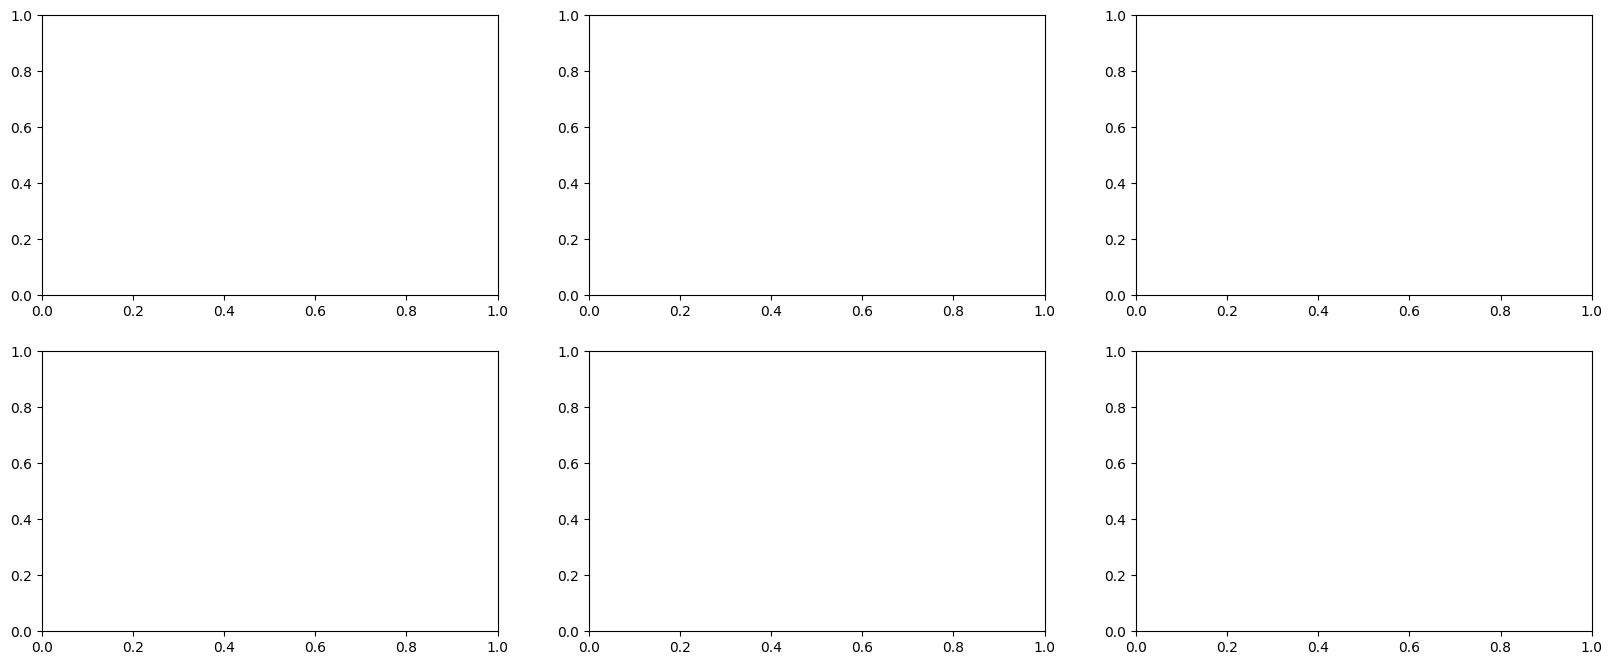

In [48]:
from lib import plot_metrics_full

plot_metrics_full(
    train_metrics_fl_iid,
    ('Global Model Test', test_metrics_fl_iid),
    # ('Centralized Train', train_metrics_centralized),
    ('Centralized Test', test_metrics_centralized),
    # ('Isolated Train', train_metrics_iid),
    ('Isolated Test', test_metrics_iid)
    )

#### Repeat experiment for non-IID local datasets

Change partitioner from iid_partitioner to a highly non-iid partitioner (pathological_partitioner)

In [49]:
# Select the shard partitioner
train_partitioner = pathological_partitioner

Evaluate performance in non federated scenario: local nodes perform training with the available dataset without any communication

In [50]:
# Train and test on all clients with pathological non-iid local dataset partitioning
train_metrics_noniid, test_metrics_noniid = train_test_all(train_partitioner, NUM_CLIENTS_NONIID, BATCH_SIZE_TRAIN, NUM_ROUNDS_NONIID, DEVICE)

Created Partition 0 - X: torch.Size([2, 192]), y: torch.Size([2, 10])
Epoch 0 Train {'loss': 0.7207891941070557, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Epoch 0 Test {'loss': 0.7038636932186052, 'accuracy': 0.0591031285307983, 'precision': 0.08112683841622143, 'recall': 0.0591031285307983, 'f1': 0.05805704031735442}
Epoch 1 Train {'loss': 0.7116026282310486, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Epoch 1 Test {'loss': 0.7031959342021569, 'accuracy': 0.05920052986324853, 'precision': 0.08073340197079157, 'recall': 0.05920052986324853, 'f1': 0.0579398214754996}
Epoch 2 Train {'loss': 0.7025001049041748, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Epoch 2 Test {'loss': 0.7025608607366973, 'accuracy': 0.059297931195698754, 'precision': 0.0801283965785202, 'recall': 0.059297931195698754, 'f1': 0.05778176116055943}
Epoch 3 Train {'loss': 0.6934832334518433, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Epoch 3 Test {'

Visualize the training and test performance in non-IID scenario without any user interaction

<Figure size 640x480 with 0 Axes>

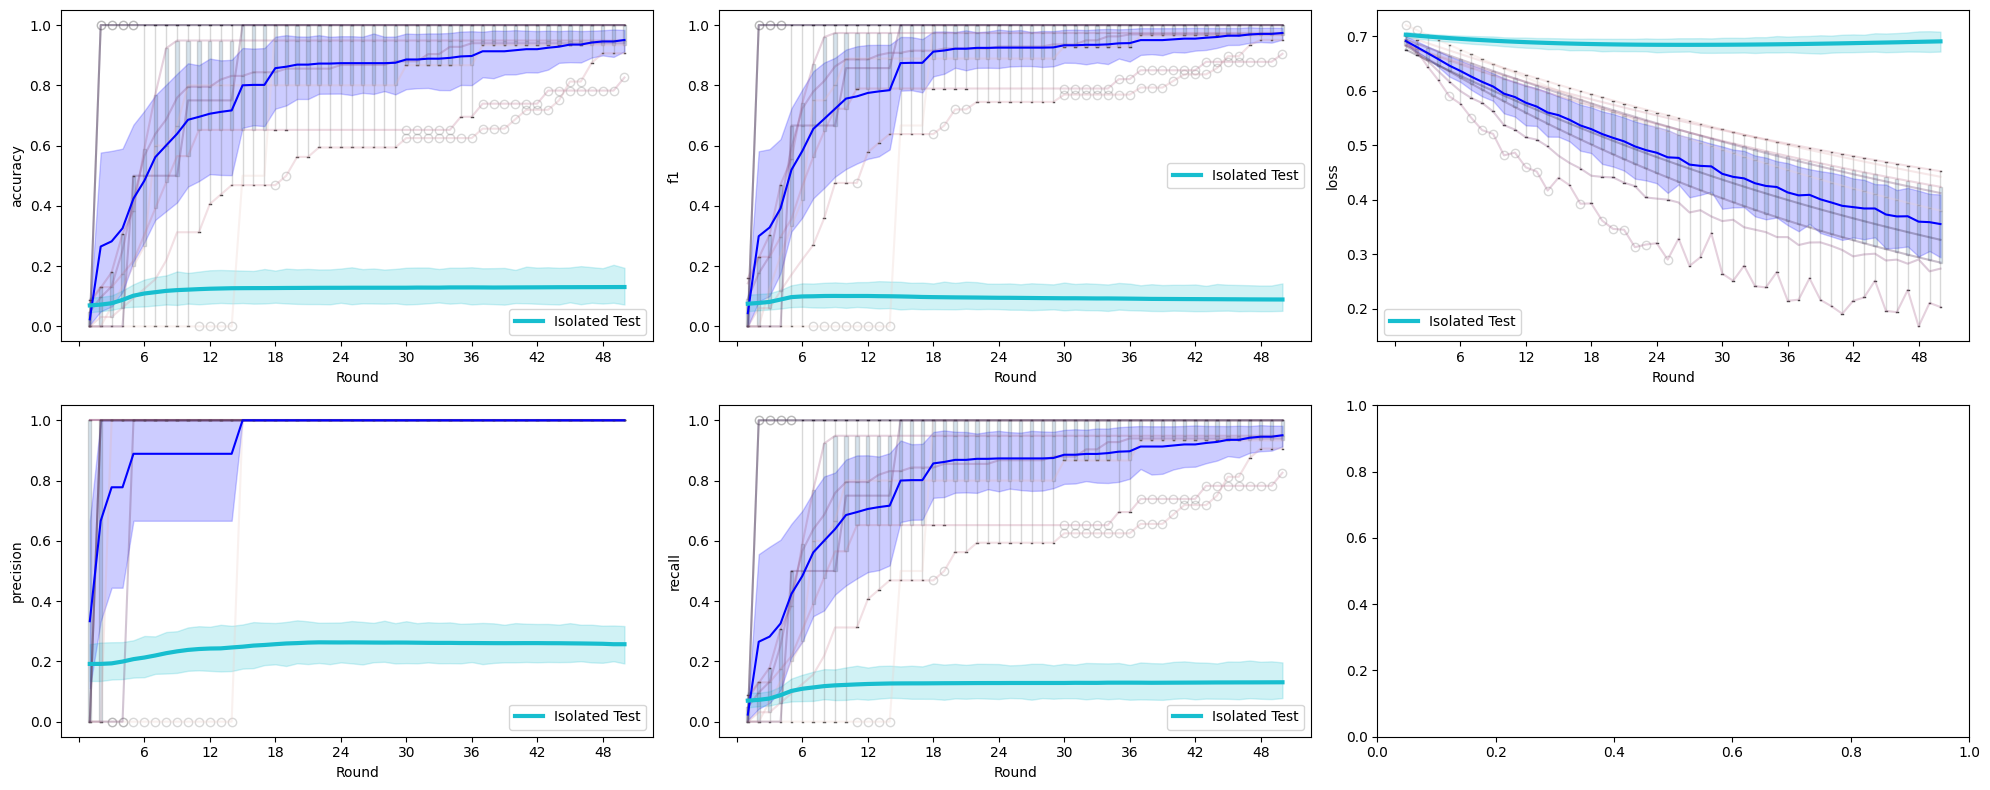

<Figure size 640x480 with 0 Axes>

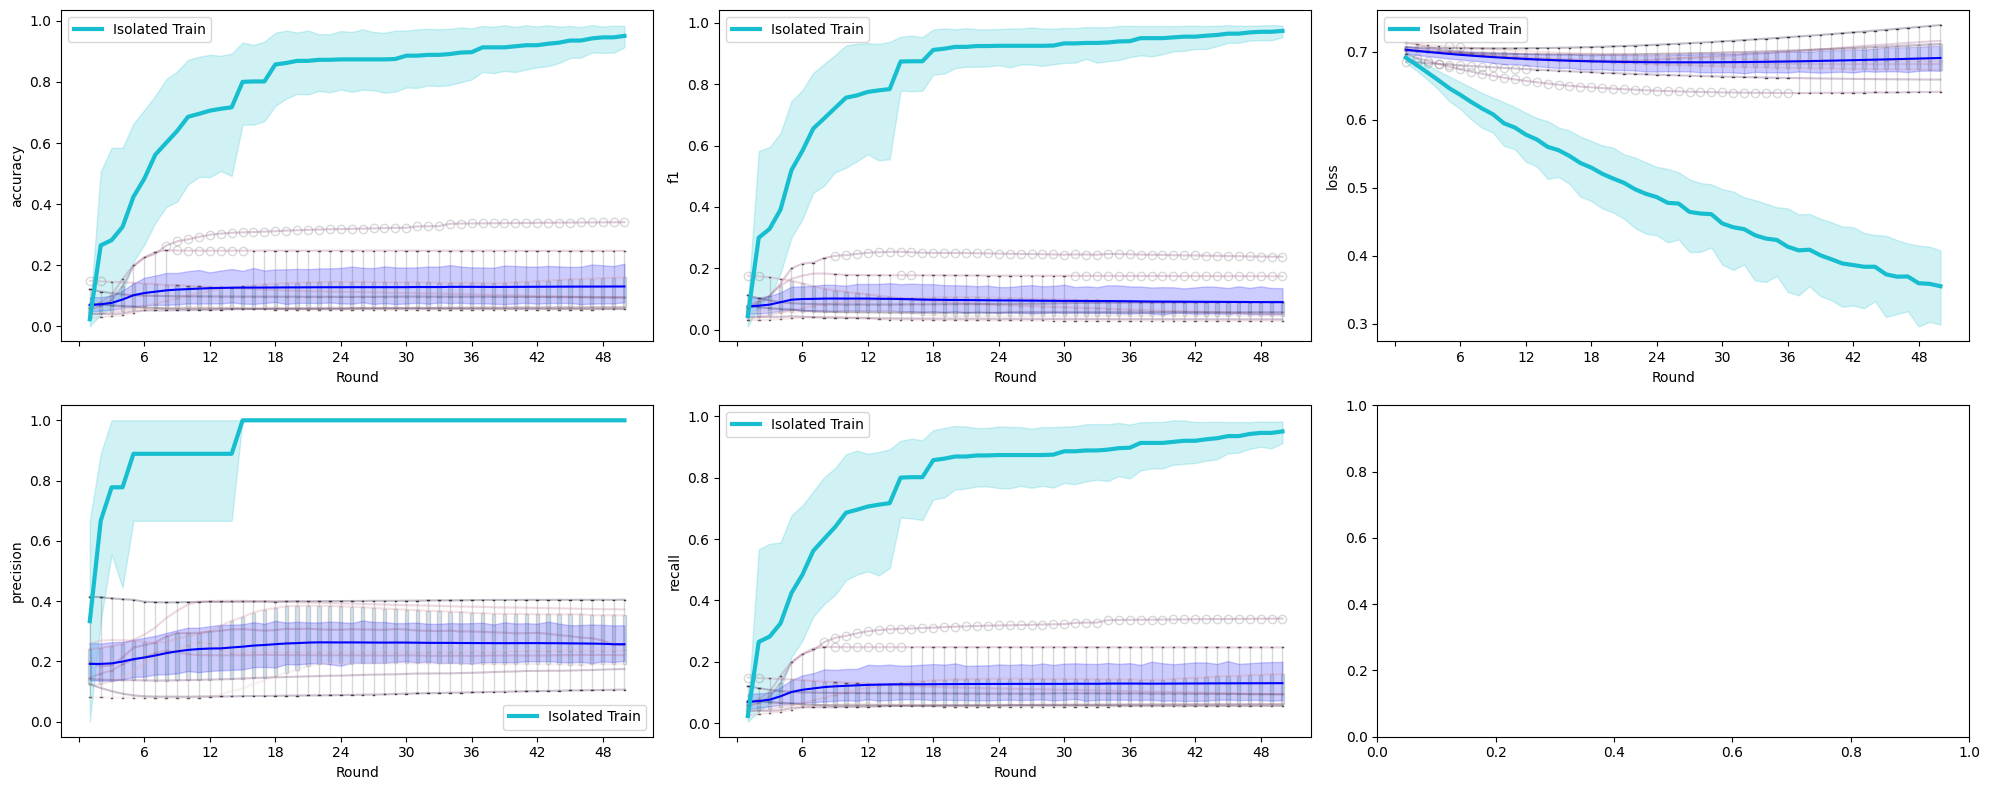

In [51]:
from lib import plot_metrics_full
# plot_metrics(train_metrics_noniid, test_metrics_noniid)
plot_metrics_full(train_metrics_noniid, ('Isolated Test', test_metrics_noniid) )
plot_metrics_full(test_metrics_noniid, ('Isolated Train', train_metrics_noniid) )

# Compare with IID partitioning
# plot_metrics(train_metrics_iid, test_metrics_iid)
# plot_metrics_full(train_metrics_iid, ('Avg. Test', test_metrics_iid))
# plot_metrics_full(test_metrics_iid, ('Avg. Train', train_metrics_iid))

Observations:

Test performance remains minimal with highly non-iid case and no model federation through device communication.

Test if Federated Learning can improve generalization performance.

In [52]:
from lib import FFNN_Tiny

# We must redefine the server strategy with the new partitioner
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a device. Configuration is provided as a `Context` object."""

    # Initialize model
    model = FFNN_Tiny(input_size, num_classes)

    # Get node id
    partition_id = context.node_config["partition-id"]

    # Read the node_config to fetch data partition associated to this node
    train_loader = get_dataloader(train_partitioner, partition_id, BATCH_SIZE_TRAIN) # train_partitioner is global

    # Report client details
    log(INFO, f"Client {partition_id} created with {len(train_loader)} mini-batches of size {BATCH_SIZE_TRAIN}") 
    
    # Get Loss function (For multi-class classification with one-hot output)
    criterion = nn.BCEWithLogitsLoss()
    
    # Create a stateful optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create and return a single Flower client representing a device
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, optimizer, criterion, train_loader, epochs_per_round=1).to_client()

# Create a new strategy
strategy = FedAvgCustom(
    fraction_fit = 1.0,  # Try to sample a proportion fraction_fit of available clients for training
    min_fit_clients = NUM_CLIENTS_NONIID,  # Min number of clients to send their updates to the server before aggregation (this is different than fraction_fit: it is a minimum hard limit, fraction_fit is a desired proportion)
    min_available_clients = NUM_CLIENTS_NONIID,  # Min number of clients that should be connected to the server (if not, the server waits)
    fit_metrics_aggregation_fn = all_metrics,  # Report all metrics for centralized evaluation
    fraction_evaluate = 0.0,  # No client evaluation
    evaluate_metrics_aggregation_fn = None, # No client evaluation --> centralized evaluation
    evaluate_fn = get_centr_eval_fn(FFNN_Tiny(input_size,num_classes).to(DEVICE), nn.BCEWithLogitsLoss()),  # Selects evaluation function (on centralized testset)
    initial_parameters = ndarrays_to_parameters(get_parameters(FFNN_Tiny(input_size,num_classes)))  # Set initial model parameters (optional)
)

Run the simulation again with the non-IID partitioner

In [ ]:
results = run_simulation(
    server_app=ServerApp(server_fn=server_fn),
    client_app=ClientApp(client_fn=client_fn),
    num_supernodes=NUM_CLIENTS_NONIID,
    backend_config=backend_config
)

INFO :      Aggregation server is using strategy: FedAvgCustom
INFO :      Starting Flower ServerApp, config: num_rounds=50, round_timeout=600s
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Calling centralized aggregated model evaluation...
INFO :      Finished. Results will be at fit_progress
INFO :      initial parameters (loss, other metrics): 0.692632774511973, {'loss': 0.692632774511973, 'accuracy': 0.10840768301710367, 'precision': 0.4999709103491398, 'recall': 0.10840768301710367, 'f1': 0.17057171354401385, 'round': 1}
INFO :      
INFO :      [ROUND 1]
ERROR :     Backend `ray`, is not supported. Use any of [] or add support for a new backend.
ERROR :     Unable to import module `ray`.

    To install the necessary dependencies, install `flwr` with the `simulation` extra:

        pip install -U "flwr[simulation]"
    
ERROR :     An exception occurred !! 

Extract the simulation results out of the Strategy object and inspect it inside the DataFrames

In [ ]:
from copy import deepcopy

test_metrics_fl_noniid = deepcopy(strategy.test_metrics)
train_metrics_fl_noniid = deepcopy(strategy.train_metrics)

test_metrics_fl_noniid
train_metrics_fl_noniid

#### Visualize performance of Federated Learning on non-IID local datasets

In [ ]:
from lib import plot_metrics_full

plot_metrics_full(
    train_metrics_fl_noniid,
    ('Global Model Test', test_metrics_fl_noniid),
    ('Centralized Train', train_metrics_centralized),
    ('Centralized Test', test_metrics_centralized),
    ('Isolated Train', train_metrics_noniid),
    ('Isolated Test', test_metrics_noniid))